In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets, ensemble
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.datasets import fetch_openml
from sklearn.linear_model import LogisticRegression,LinearRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, IsolationForest

from typing import List, Dict
import seaborn as sns
from scipy import stats
from scipy.stats import shapiro, normaltest, chi2_contingency
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [32]:
### load the df

df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")
pd.set_option('display.max_columns', None)
sns.set(color_codes=True)

In [33]:
print(df.shape)
df.head()

(60000, 24)


,sha256,size,vsize,imports,exports,has_debug,has_relocations,has_resources,has_signature,has_tls,symbols,numstrings,paths,urls,registry,MZ,printables,avlength,file_type_trid,file_type_prob_trid,A,B,C,label
0,a5d72c609a1594621e8eb775e7324d4fc291d5569cfefd...,6744064,6799360.0,524.0,3.0,0.0,1.0,1.0,0.0,1.0,0.0,64882.0,0.0,0.0,0.0,28.0,899075.0,13.857079,Win32 EXE PECompact compressed (generic),64.2,-3.978981,5.732354,er,1
1,ccaa49b76e6fd84842399c4389e2086a5a3687dfabbf01...,22016,45056.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,89.0,0.0,0.0,0.0,1.0,856.0,9.617978,Win32 Dynamic Link Library (generic),38.4,7.064133,5.738201,er,0
2,b0b126adc73b980a114e38027b082d149fcf491547452f...,686136,704512.0,133.0,4.0,1.0,1.0,1.0,1.0,0.0,0.0,2699.0,0.0,32.0,0.0,2.0,32767.0,12.140422,Win64 Executable (generic),82.0,1.052727,5.722733,gow,0
3,ff6176c53ca9b58040c93870c264843b93b5e290c28e57...,8192,36864.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,71.0,0.0,0.0,0.0,1.0,678.0,9.549296,Win64 Executable (generic),28.0,2.217531,5.896053,vh,1
4,59b8bc6ac157a553440978406c8aa8eb8a25c166af1175...,396288,421888.0,133.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,4729.0,0.0,0.0,0.0,5.0,35881.0,7.587439,Win64 Executable (generic),32.2,9.401164,NaN,vh,1


In [34]:
#calculating the number of missing values in each column of a DataFrame and creates a copy of the DataFrame with missing values filled in with 0

missing_values = df.isnull().sum()
print(missing_values)

main_df = df.copy()

sha256                    0
size                      0
vsize                  1935
imports                1739
exports                2093
has_debug              2927
has_relocations        3324
has_resources          1961
has_signature          1937
has_tls                2898
symbols                2656
numstrings             2718
paths                  3660
urls                   2349
registry               2525
MZ                     3089
printables             2739
avlength               2757
file_type_trid            0
file_type_prob_trid       0
A                      3704
B                      3751
C                      2051
label                     0
dtype: int64


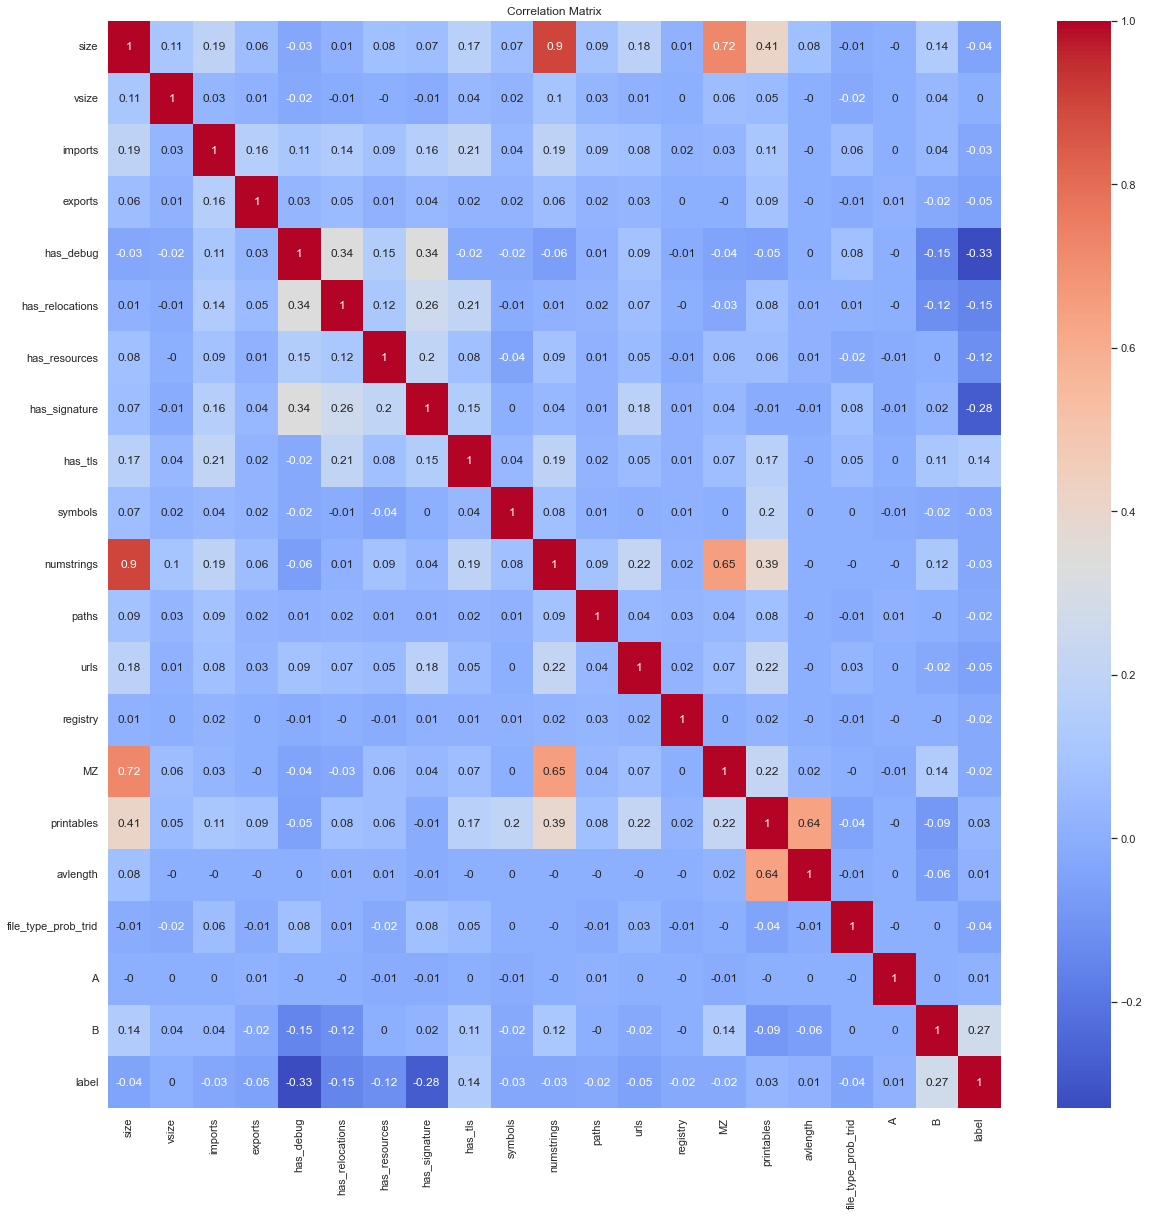

In [35]:
corr_matrix = main_df.corr().round(2)
plt.figure(figsize=(20, 20))
sns.heatmap(corr_matrix, cmap='coolwarm', annot=True)
plt.title("Correlation Matrix")
plt.show()

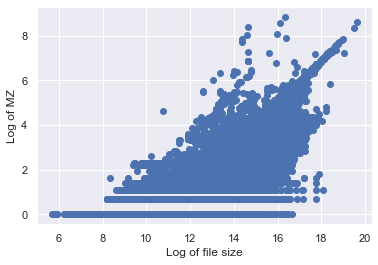

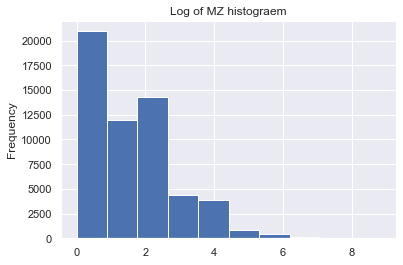

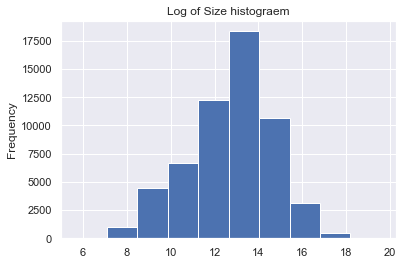

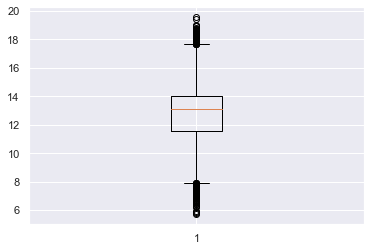

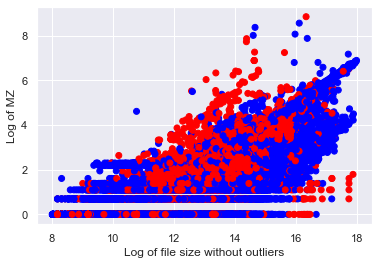

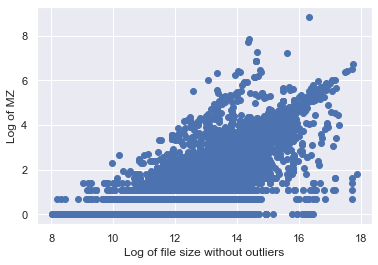

In [36]:
### understanding the MZ 

mz = main_df[main_df["MZ"] > 0]["MZ"]
size = main_df[main_df["MZ"] > 0]["size"]

logSize = np.log(size)
logMZ = np.log(mz)
plt.scatter(logSize, logMZ)
plt.xlabel("Log of file size")
plt.ylabel('Log of MZ')
plt.show()
plt.title("Log of MZ histograem")
logMZ.plot.hist()
plt.show()
plt.title("Log of Size histograem")
logSize.plot.hist()
plt.show()
plt.boxplot(logSize)
plt.show()

logSize_no_out = logSize[(logSize < 18) & (logSize > 8)]
MZ_no_out = main_df[(main_df["MZ"] > 0) & ((logSize < 18) & (logSize > 8))]["MZ"]
labels = main_df[(main_df["MZ"] > 0) & ((logSize < 18) & (logSize > 8))]['label']
label_colors = {1: 'red', 0: 'blue'}
plt.scatter(logSize_no_out, np.log(MZ_no_out), c=[label_colors[label] for label in labels])
plt.xlabel("Log of file size without outliers")
plt.ylabel('Log of MZ')
plt.show()
logSize_mal = logSize_no_out[(labels==1)]
mz_mal = MZ_no_out[(labels==1)]
plt.scatter(logSize_mal, np.log(mz_mal))
plt.xlabel("Log of file size without outliers")
plt.ylabel('Log of MZ')
plt.show()

There are 60000 observations


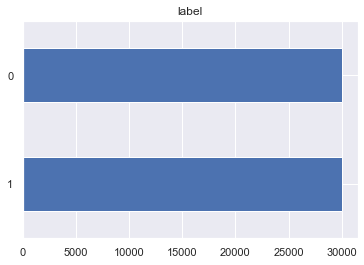

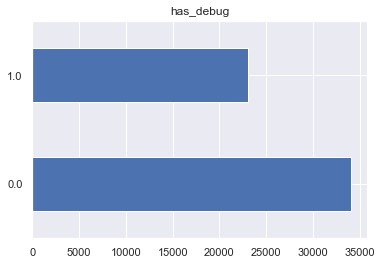

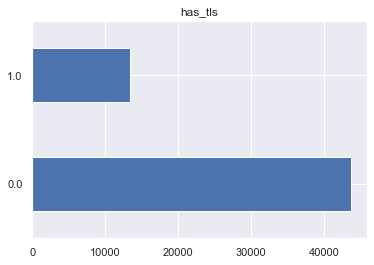

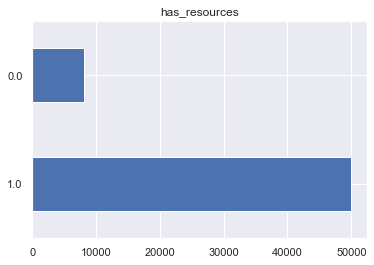

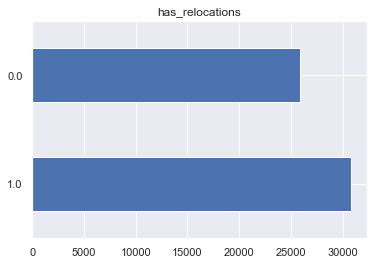

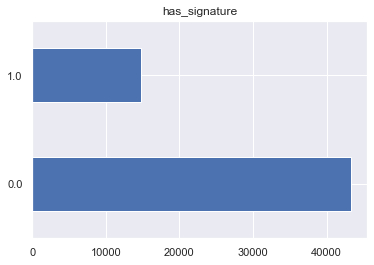

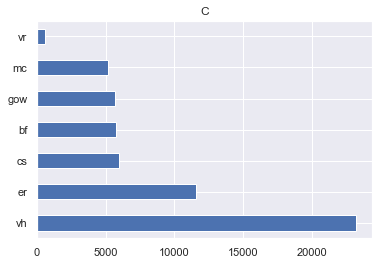

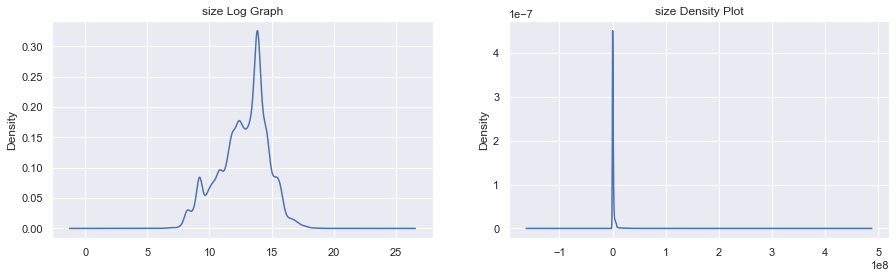

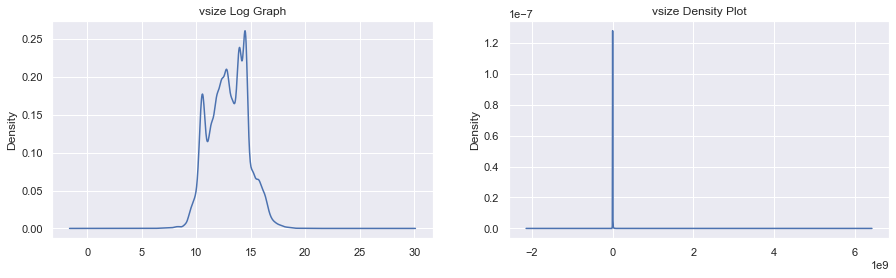

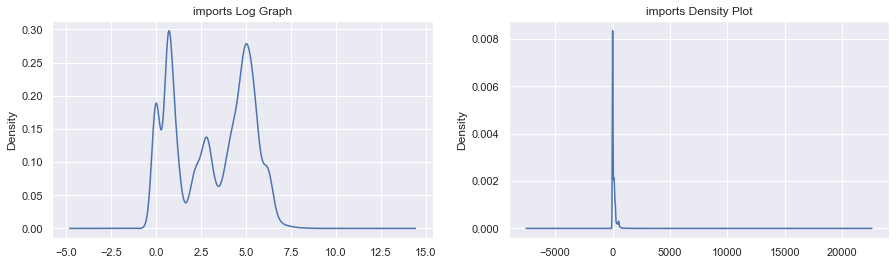

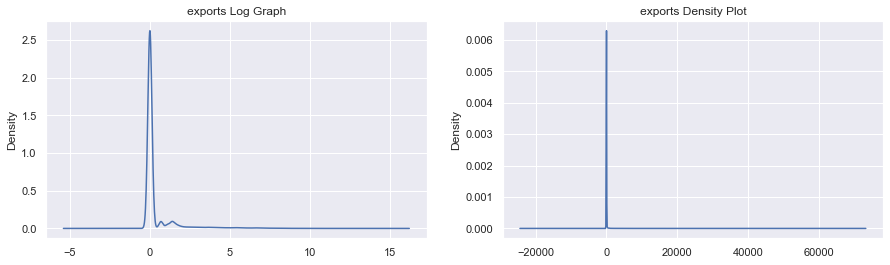

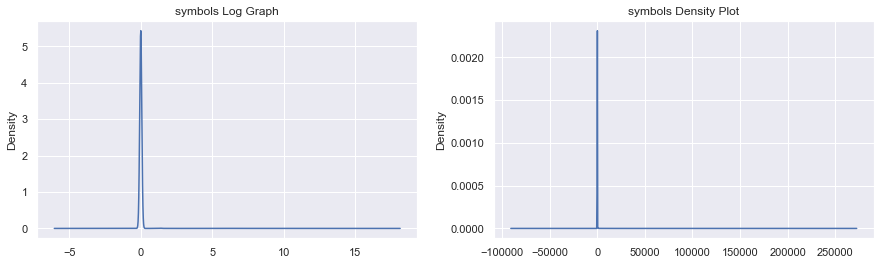

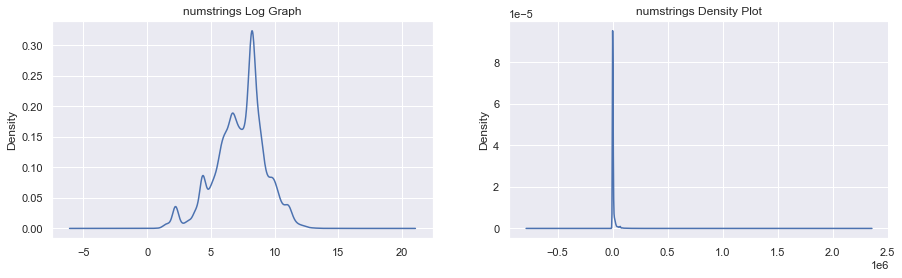

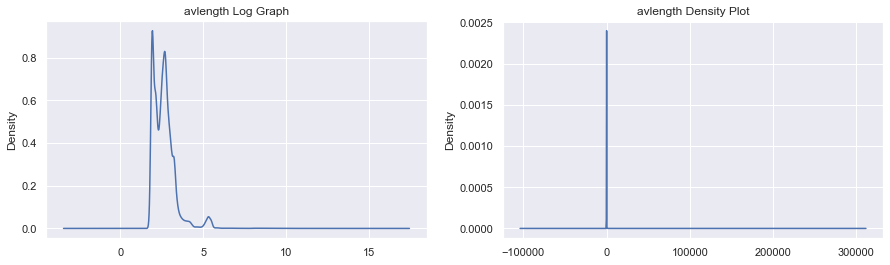

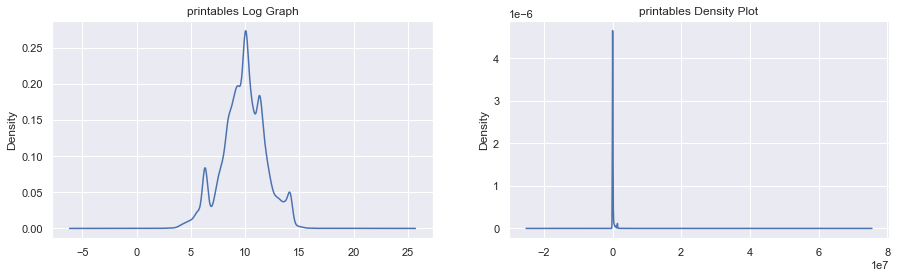

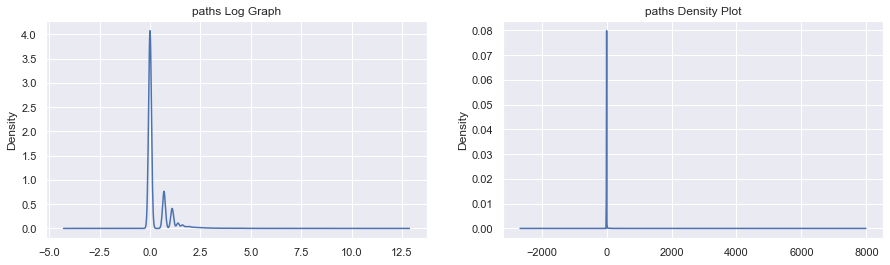

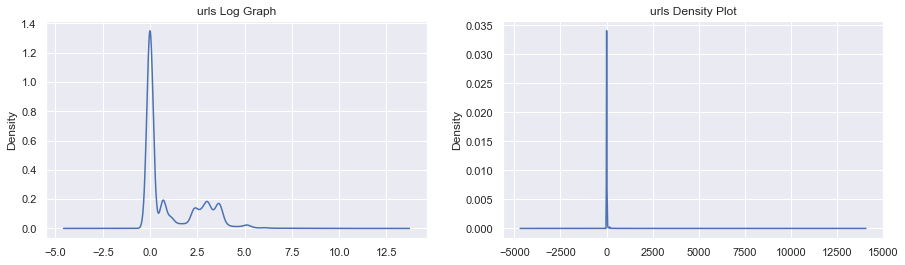

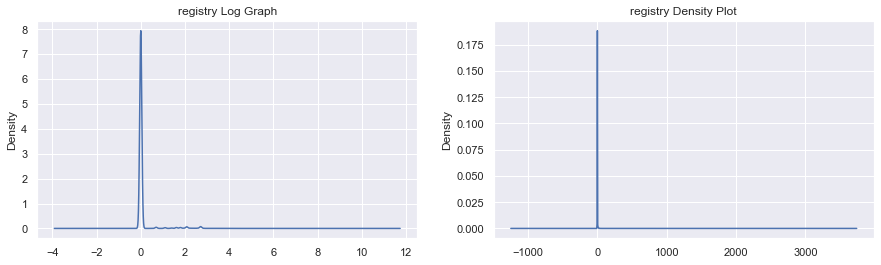

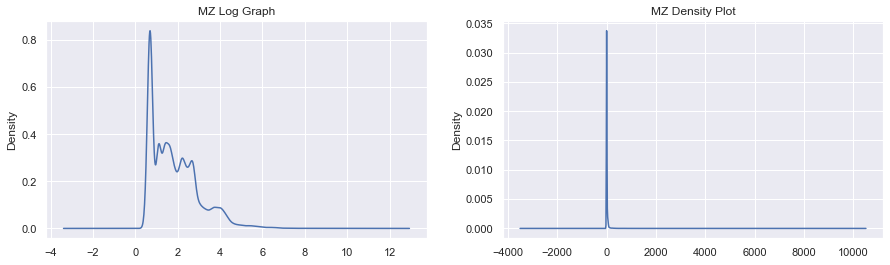

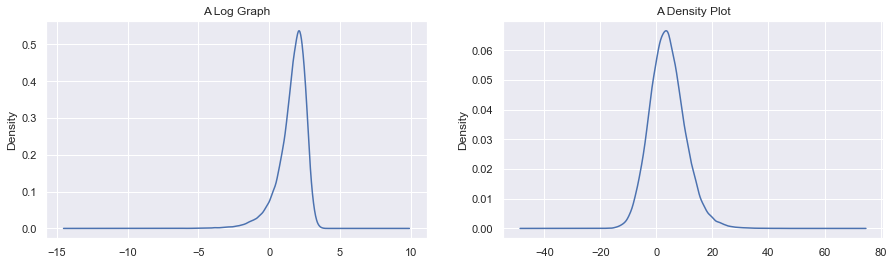

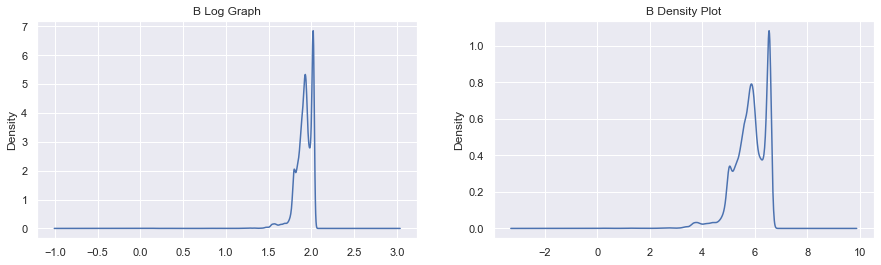

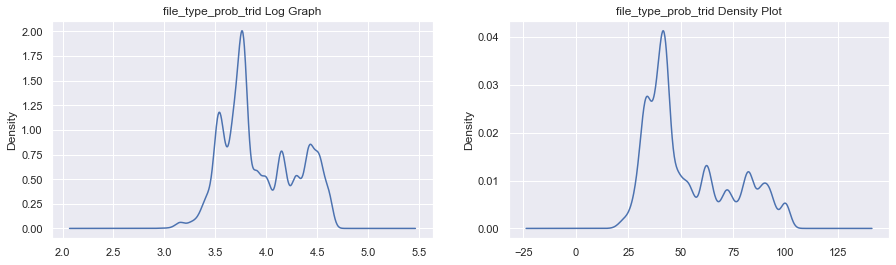

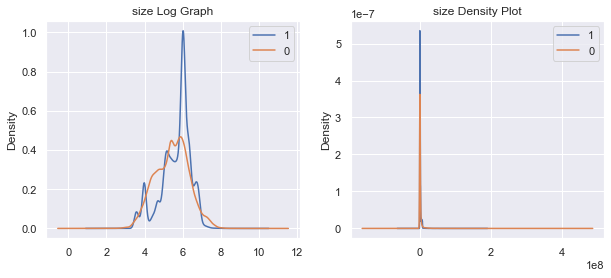

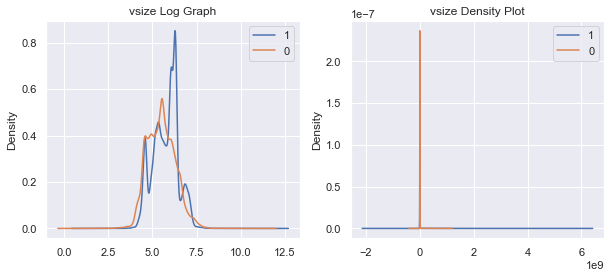

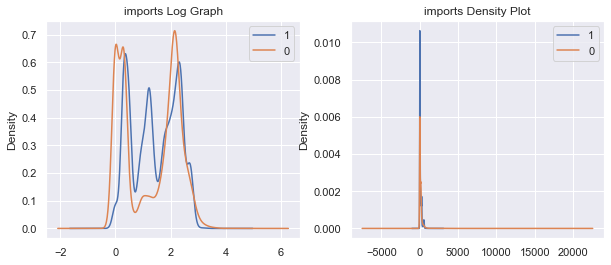

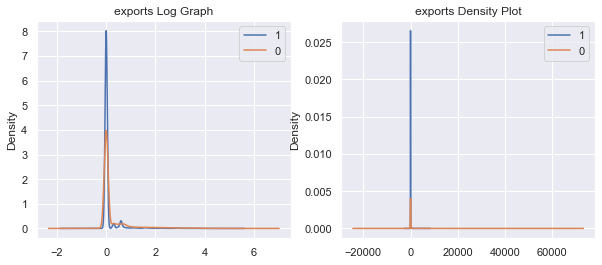

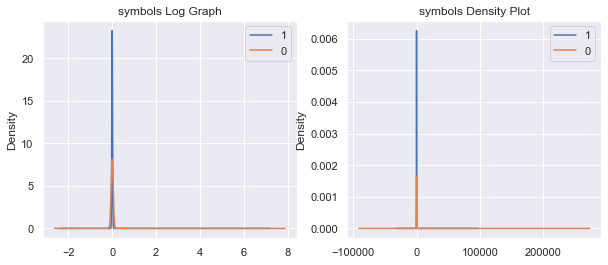

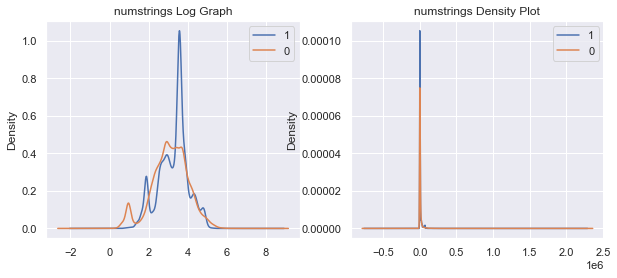

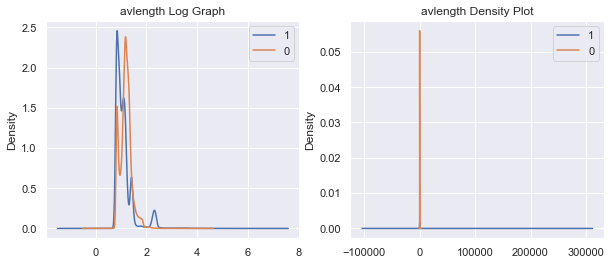

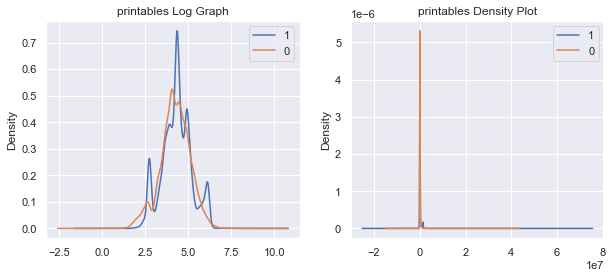

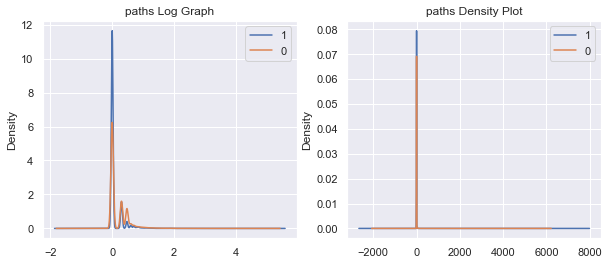

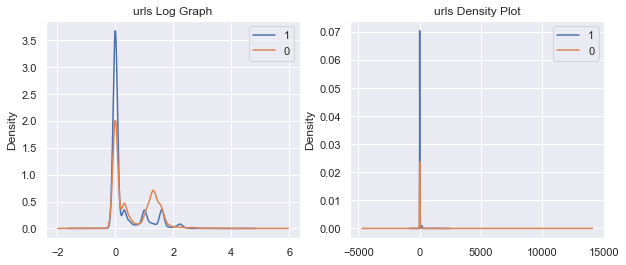

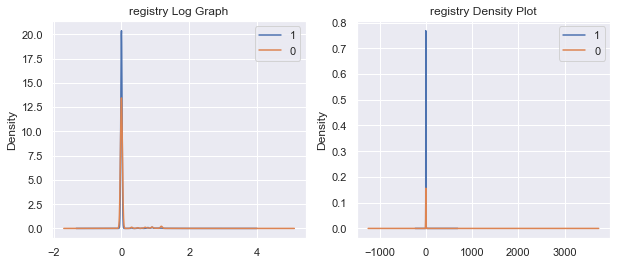

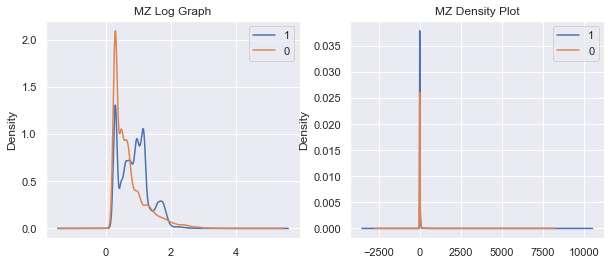

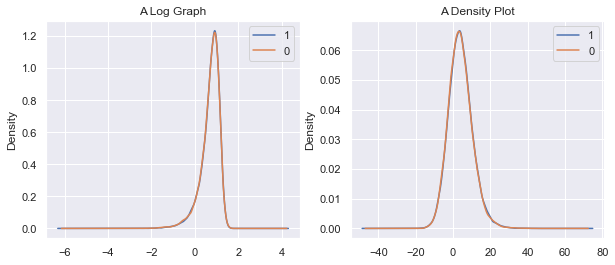

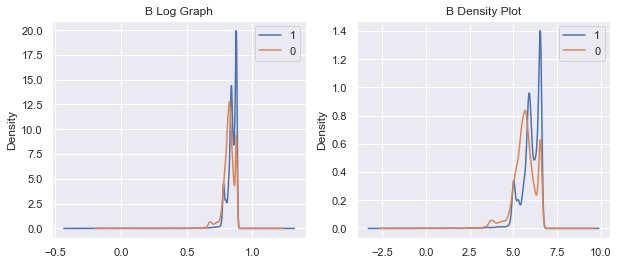

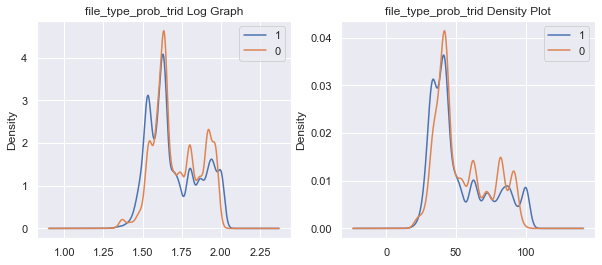

['vsize', 'Log of vsize', 'imports', 'Log of imports', 'exports', 'Log of exports', 'symbols', 'Log of symbols', 'numstrings', 'Log of numstrings', 'avlength', 'Log of avlength', 'printables', 'Log of printables', 'paths', 'Log of paths', 'urls', 'Log of urls', 'registry', 'Log of registry', 'MZ', 'Log of MZ', 'A', 'Log of A', 'B', 'Log of B']


'\nfeatures that look normally distributed:\nA\nlog of size\nlog of numstrings\nfeatures that log will increase the variance\nMZ\nurl\npaths\navlength\nsymbols, exports and imports\n\n\n'

In [37]:
### plotting all the features 

#some basic steps i think are important
num_features = df.shape[1]
num_observations = df.shape[0]
print(f"There are {num_observations} observations")

catagorial = ['label', 'has_debug', 'has_tls', 'has_resources', 'has_relocations', 'has_signature', 'C','file_type_trid']
numerical = ['size', 'vsize', 'imports', 'exports', 'symbols', 'numstrings', 'avlength', 'printables', 'paths', 'urls', 'registry', 'MZ', 'A', 'B', 'file_type_prob_trid']

norm_features = []
# Creating a boxplot for each numerical feature

ones = np.ones(main_df.shape[0])
for cat in catagorial:
    if ('type' in cat):
        continue
    main_df[cat].value_counts().plot.barh()
    plt.title(cat)
    plt.show()

# not by labels
for cat in numerical:

    fig, axes = plt.subplots(1, 2, figsize=(15, 4))

    curr = np.log(ones + main_df[cat])
    curr.plot.density( ax=axes[0])

    
    main_df['Log of '+cat] = curr

    main_df[cat].plot.density(ax=axes[1])

    axes[0].set_title(cat + " Log Graph")
    axes[1].set_title(cat + " Density Plot")

    plt.show()

# by labels
for cat in numerical:

    fig, axes = plt.subplots(1, 2, figsize=(10 , 4))

    curr = np.log10(ones + main_df[cat])
    curr[main_df['label'] == 1].plot.density(ax=axes[0], label = '1')
    curr[main_df['label'] == 0].plot.density(ax=axes[0], label= '0')

    
    main_df['Log of '+cat] = curr

    main_df[main_df['label'] == 1][cat].plot.density(ax=axes[1], label= '1')
    main_df[main_df['label'] == 0][cat].plot.density(ax=axes[1], label= '0')

    axes[0].legend()
    axes[1].legend()
    axes[0].set_title(cat + " Log Graph")
    axes[1].set_title(cat + " Density Plot")

    plt.show()
    test_statistic, p_value = stats.shapiro(main_df[cat])
    if (p_value > 0.05):
        norm_features = norm_features + [cat]
    test_statistic, p_value = stats.shapiro(curr)
    if (p_value > 0.05):
        norm_features = norm_features + ['Log of '+cat]


print(norm_features)
main_df.describe()  


'''
features that look normally distributed:
A
log of size
log of numstrings
features that log will increase the variance
MZ
url
paths
avlength
symbols, exports and imports


'''

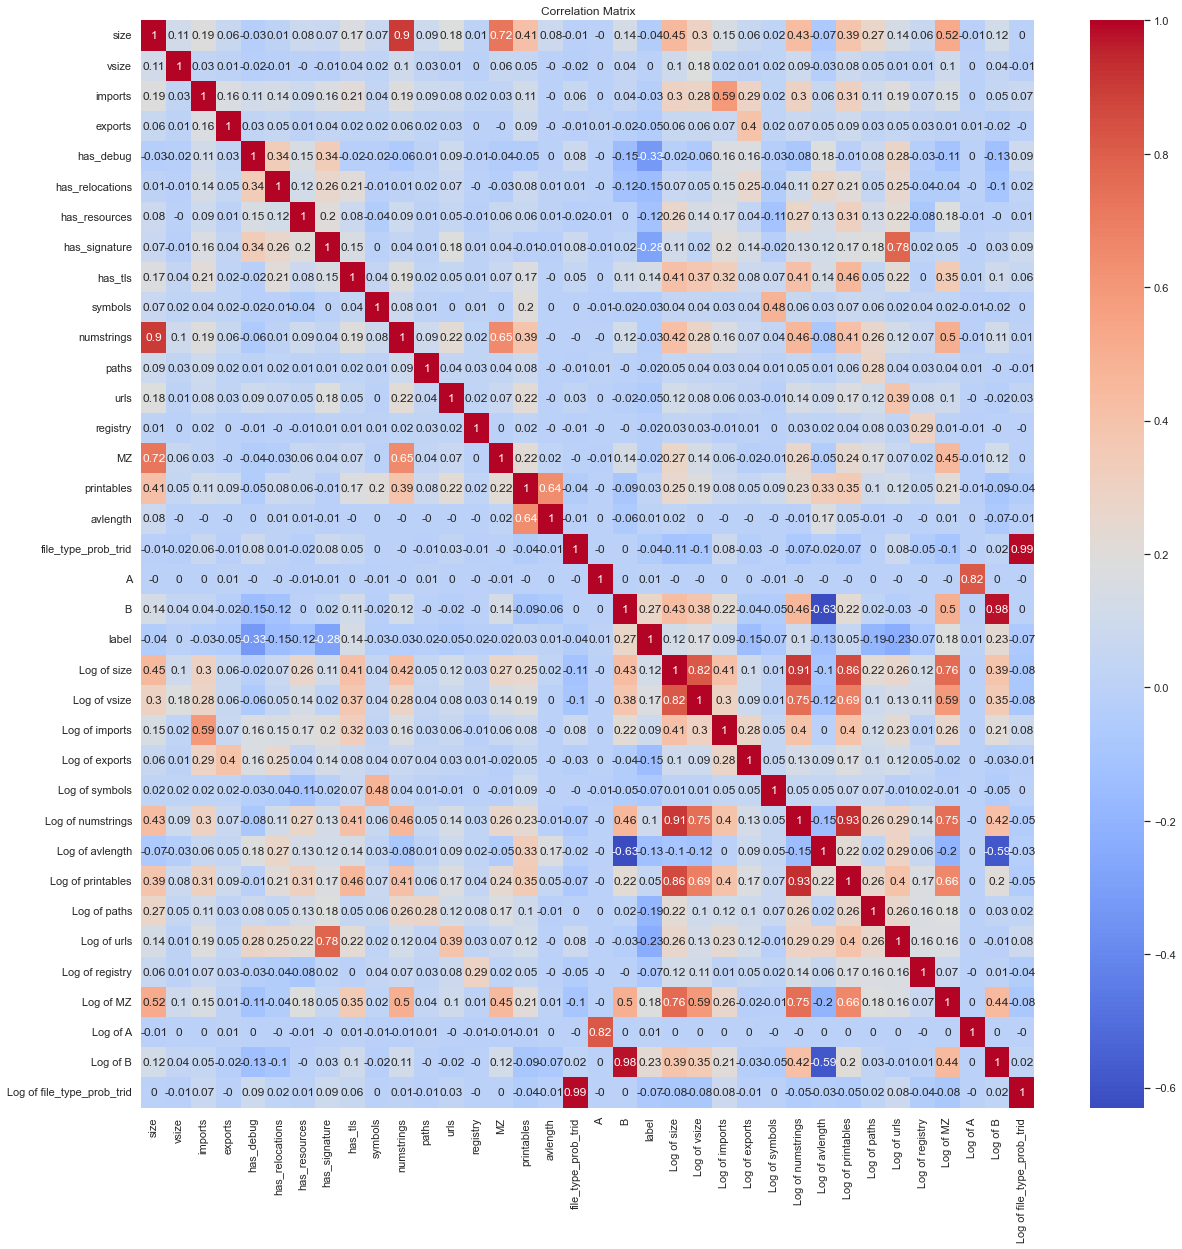

In [104]:
normal_log = ['size', 'numstrings']
to_log = ['size', 'vsize','numstrings','printables', 'MZ', 'urls', 'paths', 'avlength' ,'symbols', 'exports', 'imports', 'registry']
corr_matrix = main_df.corr().round(2)
plt.figure(figsize=(20, 20))
sns.heatmap(corr_matrix, cmap='coolwarm', annot=True)
plt.title("Correlation Matrix")
plt.show()

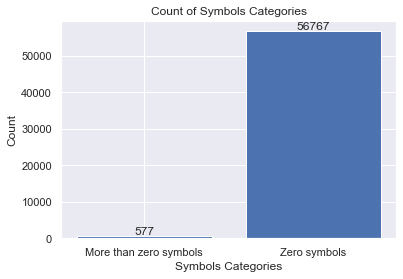

In [39]:
more_than_zero_symbols = len(main_df[main_df['symbols'] > 0])
zero_symbols = len(main_df[main_df['symbols'] == 0])

symbols_categories = ['More than zero symbols', 'Zero symbols']
symbols_counts = [more_than_zero_symbols, zero_symbols]

plt.bar(symbols_categories, symbols_counts)
plt.xlabel('Symbols Categories')
plt.ylabel('Count')
plt.title('Count of Symbols Categories')

# Add numbers on top of each bar
for i, count in enumerate(symbols_counts):
    plt.text(i, count, str(count), ha='center', va='bottom')
    
plt.show()

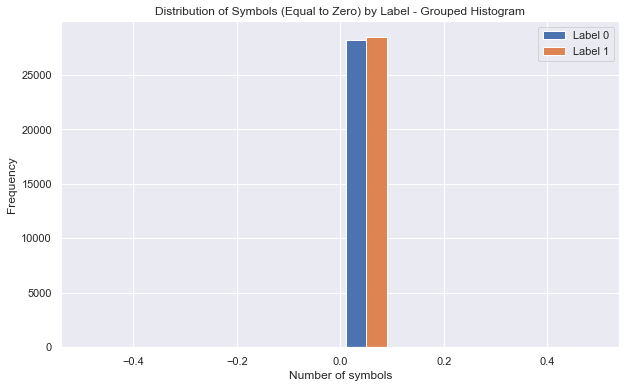

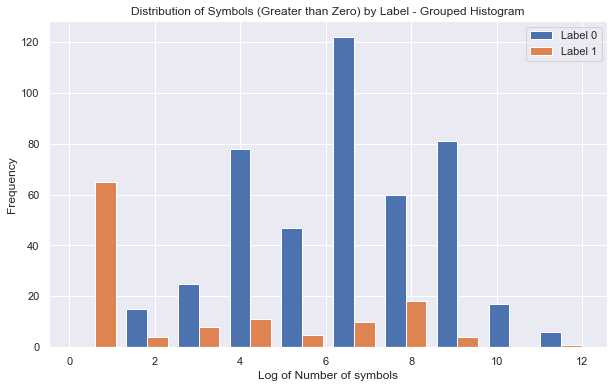

In [40]:

zero_symbols_label_0 = main_df[(main_df['symbols'] == 0) & (main_df['label'] == 0)]['symbols']
zero_symbols_label_1 = main_df[(main_df['symbols'] == 0) & (main_df['label'] == 1)]['symbols']
plt.figure(figsize=(10, 6))
# Grouped Histogram
plt.hist([zero_symbols_label_0, zero_symbols_label_1], bins=10, label=['Label 0', 'Label 1'])
plt.xlabel('Number of symbols')
plt.ylabel('Frequency')
plt.title('Distribution of Symbols (Equal to Zero) by Label - Grouped Histogram')
plt.legend()
plt.show()

bigger_zero_symbols_label_0 = main_df[(main_df['symbols'] > 0) & (main_df['label'] == 0)]['symbols']
bigger_zero_symbols_label_1 = main_df[(main_df['symbols'] > 0) & (main_df['label'] == 1)]['symbols']
plt.figure(figsize=(10, 6))
bigger_zero_symbols_label_0_log = np.log(bigger_zero_symbols_label_0)
bigger_zero_symbols_label_1_log = np.log(bigger_zero_symbols_label_1)
# Grouped Histogram
plt.hist([bigger_zero_symbols_label_0_log, bigger_zero_symbols_label_1_log], bins=10, label=['Label 0', 'Label 1'])
plt.xlabel('Log of Number of symbols')
plt.ylabel('Frequency')
plt.title('Distribution of Symbols (Greater than Zero) by Label - Grouped Histogram')
plt.legend()
plt.show()



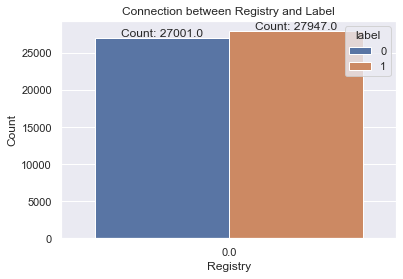

Number of Labels that are 1 with registry 0: 27947
Number of Labels that are 0 with registry 0: 27001


In [41]:
df_registry_0 = main_df[main_df['registry']==0]

# Create a count plot
ax = sns.countplot(data=df_registry_0, x='registry', hue='label')

# Get the counts
label_1_registry_0 = len(df_registry_0[df_registry_0['label'] == 1])
label_0_registry_0 = len(df_registry_0[df_registry_0['label'] == 0])

# Annotate the bars with count values
for p in ax.patches:
    if p.get_height() > 0:
        ax.annotate(f"Count: {p.get_height()}", (p.get_x() + p.get_width() / 2, p.get_height()), 
                    ha='center', va='bottom')

# Set labels and title
plt.xlabel('Registry')
plt.ylabel('Count')
plt.title('Connection between Registry and Label')

# Display the plot
plt.show()

# Print the counts
print(f"Number of Labels that are 1 with registry 0: {label_1_registry_0}")
print(f"Number of Labels that are 0 with registry 0: {label_0_registry_0}")

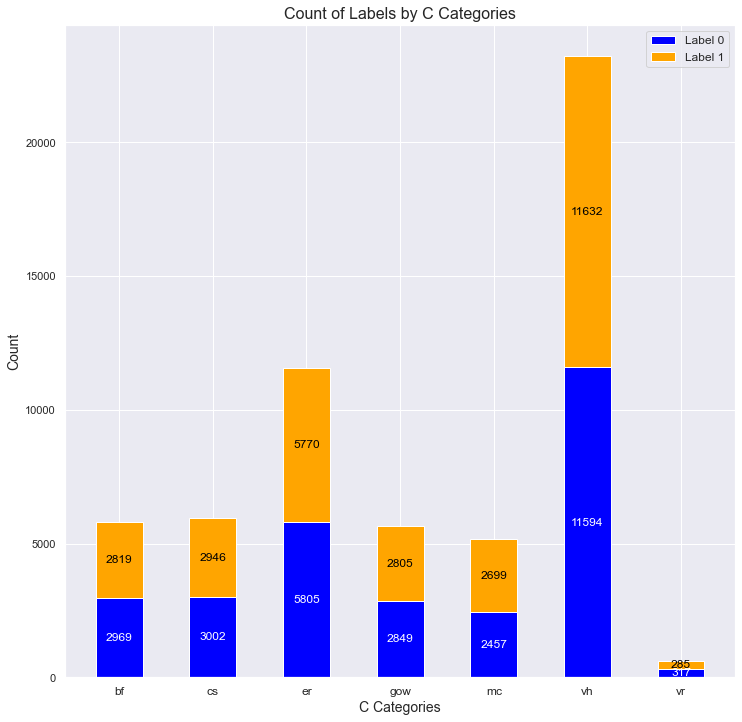

In [42]:
#comparing the distribution of safe and malicious files across different categories ('C'). 
grouped_data = main_df.groupby(['C', 'label']).size().unstack()
plt.figure(figsize=(12, 12))
colors = ['blue', 'orange']
num_categories = len(grouped_data)
bar_width = 0.5
bar_positions = np.arange(num_categories)
plt.bar(bar_positions, grouped_data[0], color=colors[0], width=bar_width, label='Label 0')
plt.bar(bar_positions, grouped_data[1], color=colors[1], width=bar_width, bottom=grouped_data[0], label='Label 1')
plt.xticks(bar_positions, grouped_data.index)
plt.xticks(bar_positions, grouped_data.index, fontsize=12)
plt.xlabel('C Categories', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.title('Count of Labels by C Categories', fontsize=16)
plt.legend(fontsize=12)

# Increase the gap between count numbers
label_0_offset = 0.15
label_1_offset = 0.3

# Add numbers for label 0
for i in range(num_categories):
    plt.text(bar_positions[i], grouped_data.iloc[i, 0] / 2, f'{grouped_data.iloc[i, 0]}', ha='center', va='center', color='white')

# Add numbers for label 1
for i in range(num_categories):
    plt.text(bar_positions[i], grouped_data.iloc[i, 0] + grouped_data.iloc[i, 1] / 2, f'{grouped_data.iloc[i, 1]}', ha='center', va='center', color='black')

plt.show()

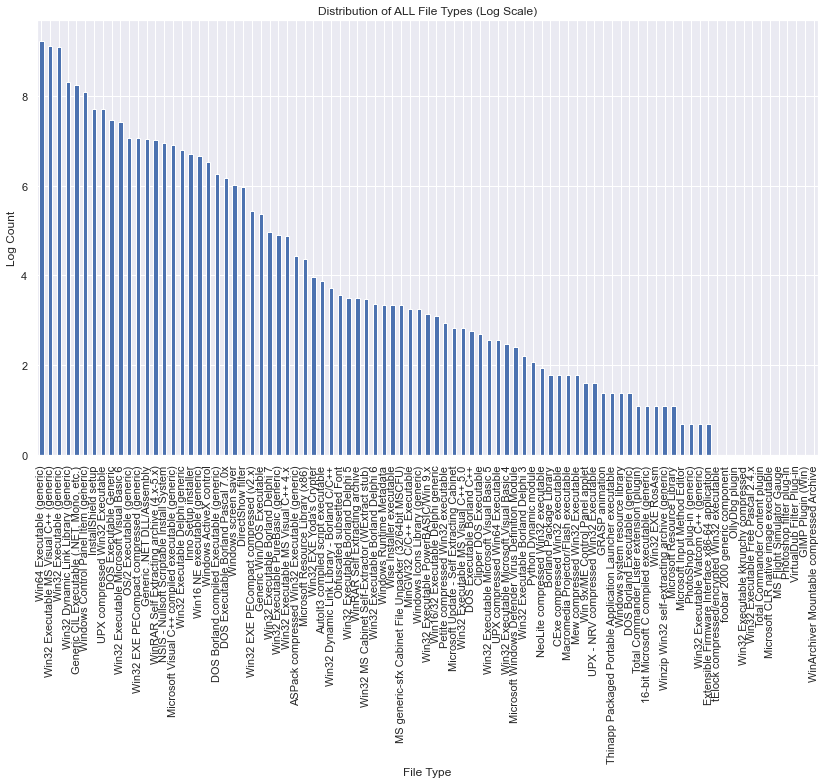

In [43]:
file_type_counts = main_df['file_type_trid'].value_counts()
log_counts = np.log(file_type_counts)

# Plot the bar chart with log-transformed counts
plt.figure(figsize=(14, 8))
log_counts.plot(kind='bar')
plt.xlabel('File Type')
plt.ylabel('Log Count')
plt.title('Distribution of ALL File Types (Log Scale)')
plt.xticks(rotation=90)
plt.show()

Win32 EXE 


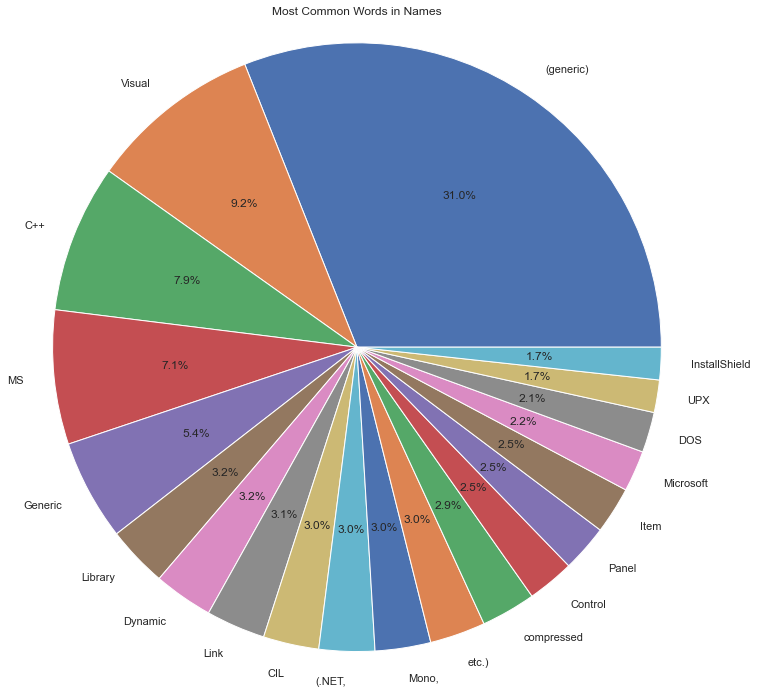

In [44]:
all_names = ' '.join(main_df['file_type_trid'].astype(str))
print(all_names[:10])
# Split the string into individual words
words = all_names.split()

# Create a dictionary to store word frequencies
word_counts = {}
excluded_words = ["win", "exe"]
# Count the frequency of each word
for word in words:
    #check if redundant
    if any(ex in word.lower() for ex in excluded_words):
        continue

    if word in word_counts:
        word_counts[word] += 1
    else:
        word_counts[word] = 1
    

# Sort the word frequencies in descending order
sorted_counts = sorted(word_counts.items(), key=lambda x: x[1], reverse=True)

# Get the most common words and their counts
most_common_words = sorted_counts[:20]  # Adjust the number (5 in this case) as desired

# Extract the labels and counts from the most common words
labels = [word[0] for word in most_common_words]
counts = [word[1] for word in most_common_words]

# Plot the pie chart
plt.figure(figsize=(12, 12))
plt.pie(counts, labels=labels, autopct='%1.1f%%')
plt.title('Most Common Words in Names')
plt.axis('equal')
plt.show()

In [45]:
#we can make new features of: is_exe, is_generic and is_win32
cat_df = df.copy()
c_test = test_df.copy()
# Create new features
top_words = ['generic', 'visual']
#we want for every word in the top 10 to be 0 if the word includes it or 1 if doesnt

for word in top_words:
    col_name = 'is_'+word
    cat_df[col_name] = np.zeros(cat_df.shape[0])
    c_test[col_name] = np.zeros(c_test.shape[0])
    cat_df.loc[cat_df['file_type_trid'].str.lower().str.contains(word), col_name] = 1
    c_test.loc[test_df['file_type_trid'].str.lower().str.contains(word), col_name] = 1

col_name = "is_C++"
cat_df[col_name] = np.zeros(cat_df.shape[0])
c_test[col_name] = np.zeros(c_test.shape[0])
cat_df.loc[cat_df['file_type_trid'].str.contains('C+'), col_name] = 1
c_test.loc[c_test['file_type_trid'].str.contains('C+'), col_name] = 1

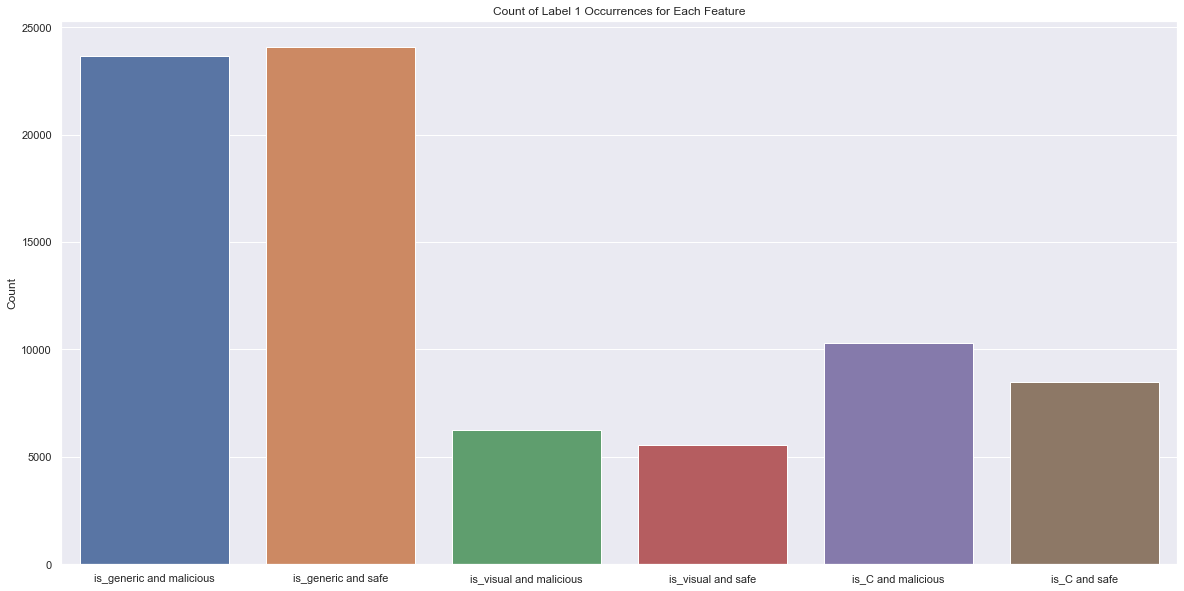

In [46]:
counts = [
    len(cat_df[(cat_df['is_generic'] == 1) & (cat_df['label'] == 1)]),
    len(cat_df[(cat_df['is_generic'] == 1) & (cat_df['label'] == 0)]),
    len(cat_df[(cat_df['is_visual'] == 1) & (cat_df['label'] == 1)]),
    len(cat_df[(cat_df['is_visual'] == 1) & (cat_df['label'] == 0)]),
    len(cat_df[(cat_df['is_C++'] == 1) & (cat_df['label'] == 1)]),
    len(cat_df[(cat_df['is_C++'] == 1) & (cat_df['label'] == 0)])
]

# Create a bar plot
plt.figure(figsize=(20,10))
sns.barplot(x=['is_generic and malicious','is_generic and safe', 'is_visual and malicious', 'is_visual and safe', 'is_C and malicious', 'is_C and safe'], y=counts)
plt.title('Count of Label 1 Occurrences for Each Feature')

plt.ylabel('Count')
plt.show()


In [58]:
### Chi Sq test to check contingency between the words and labels

for feature in ['is_generic', 'is_visual', 'is_C++']:
    contingency_table = pd.crosstab(cat_df[feature], cat_df['label'])
    chi2, p_value, _, _ = chi2_contingency(contingency_table)
    
    print(f"Feature: {feature}")
    print(f"Contingency Table:\n{contingency_table}\n")
    print(f"Chi-square statistic: {chi2}")
    print(f"P-value:{p_value:.10f}")
    print("")

## P-value is very small
### CHECK LATER TO MAKE IT  EVEN BETTER

Feature: is_generic
Contingency Table:
label           0      1
is_generic              
0.0          5906   6330
1.0         24094  23670

Chi-square statistic: 18.3692670175601
P-value:0.0000181970

Feature: is_visual
Contingency Table:
label          0      1
is_visual              
0.0        24439  23760
1.0         5561   6240

Chi-square statistic: 48.49018040284746
P-value:0.0000000000

Feature: is_C++
Contingency Table:
label       0      1
is_C++              
0.0     21516  19705
1.0      8484  10295

Chi-square statistic: 253.93198924776573
P-value:0.0000000000



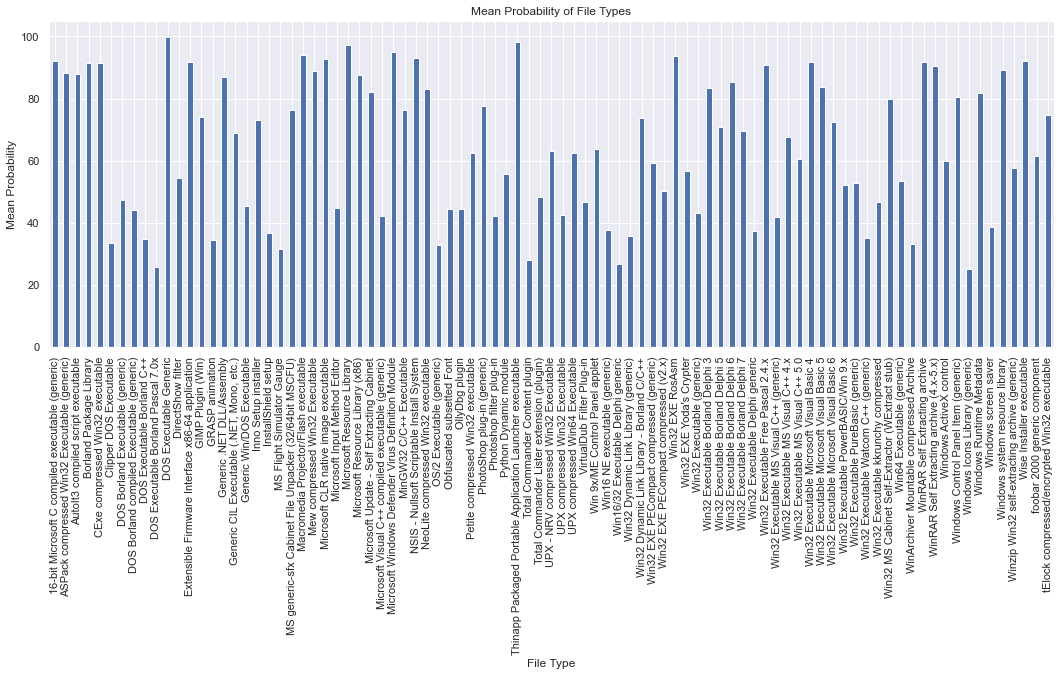

In [47]:
#In this code, we group the data by "file_type_trid" and calculate the mean probability ("file_type_prob_trid") for each file type. 
# Then, we create a bar plot where each bar represents a file type, 
# and the height of each bar corresponds to the mean probability of that file type.

# Group the data by file_type_trid and calculate the mean probability for each file type
file_type_prob_means = main_df.groupby('file_type_trid')['file_type_prob_trid'].mean()

# Plot the bar chart
plt.figure(figsize=(18, 6))
file_type_prob_means.plot(kind='bar')
plt.xlabel('File Type')
plt.ylabel('Mean Probability')
plt.title('Mean Probability of File Types')
plt.xticks(rotation=90)
plt.show()

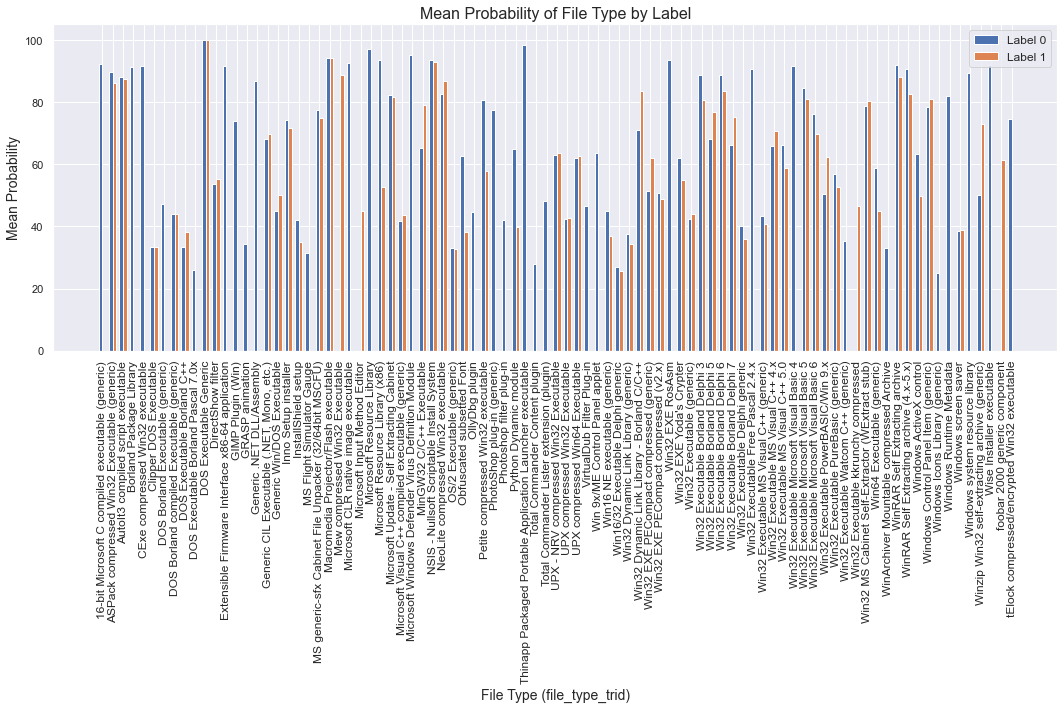

In [48]:
# Group the data by file_type_trid and label, and calculate the mean probabilities
grouped_data = main_df.groupby(['file_type_trid', 'label'])['file_type_prob_trid'].mean().unstack()

# Plotting the grouped bar chart
plt.figure(figsize=(18, 6))
bar_width = 0.35
bar_positions = np.arange(len(grouped_data))

# Plot bars for label 0
plt.bar(bar_positions - bar_width/2, grouped_data[0], width=bar_width, label='Label 0')

# Plot bars for label 1
plt.bar(bar_positions + bar_width/2, grouped_data[1], width=bar_width, label='Label 1')

plt.xlabel('File Type (file_type_trid)', fontsize=14)
plt.ylabel('Mean Probability', fontsize=14)
plt.title('Mean Probability of File Type by Label', fontsize=16)
plt.xticks(bar_positions, grouped_data.index, rotation=90, fontsize=12)
plt.legend(fontsize=12)

plt.show()

#when the mean probabiliy is high there are more label 0 (safe files)

Top 5 Files with the Highest Label 1 Percentages:
file_type_trid
Mew compressed Win32 Executable                   100.00000
Microsoft Input Method Editor                     100.00000
Win32 Executable kkrunchy compressed              100.00000
foobar 2000 generic component                     100.00000
Winzip Win32 self-extracting archive (generic)     59.24421
dtype: float64

Average Probabilities for the Top 5 Files:
file_type_trid
Mew compressed Win32 Executable                   88.8
Microsoft Input Method Editor                     44.9
Win32 Executable kkrunchy compressed              46.7
foobar 2000 generic component                     61.5
Winzip Win32 self-extracting archive (generic)    72.9
Name: 1, dtype: float64


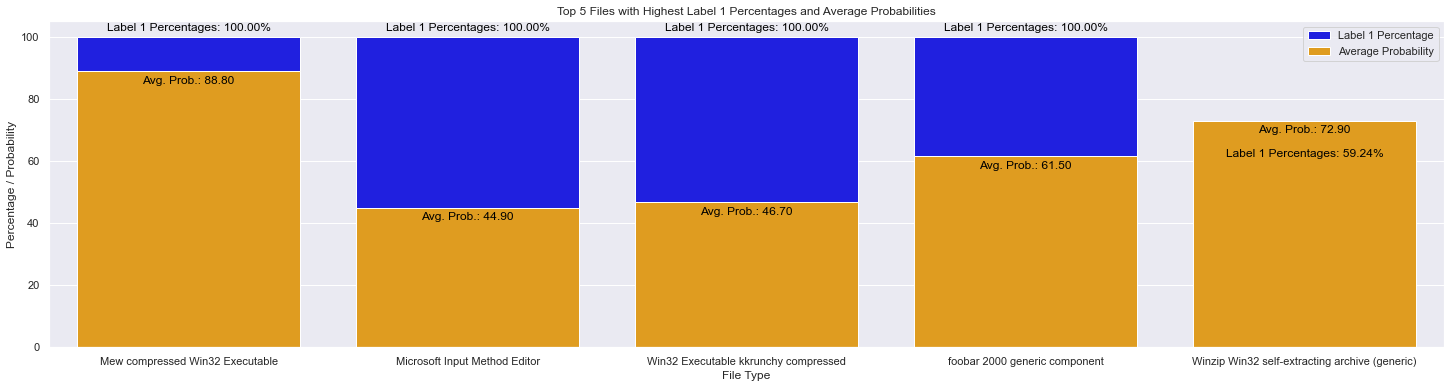

In [49]:
# Group the data by file_type_trid and label, and calculate the mean probabilities
grouped_data = main_df.groupby(['file_type_trid', 'label'])['file_type_prob_trid'].mean().unstack().fillna(0)

# Calculate the percentage of label 1 for each file type
total_counts = grouped_data.sum(axis=1)
label1_percent = grouped_data[1] / total_counts * 100

# Find the top 5 files with the highest label 1 percentages
top_label1_files = label1_percent.nlargest(5)
print("Top 5 Files with the Highest Label 1 Percentages:")
print(top_label1_files)
print()

# Calculate the average probabilities for the top 5 files
average_probabilities = grouped_data.loc[top_label1_files.index, 1]
print("Average Probabilities for the Top 5 Files:")
print(average_probabilities)

# Plot the label 1 percentages and average probabilities for the top 5 files
plt.figure(figsize=(25, 6))
sns.barplot(x=top_label1_files.index, y=top_label1_files.values, color='blue', label='Label 1 Percentage')
sns.barplot(x=top_label1_files.index, y=average_probabilities, color='orange', label='Average Probability')
plt.xlabel('File Type')
plt.ylabel('Percentage / Probability')
plt.title('Top 5 Files with Highest Label 1 Percentages and Average Probabilities')
for i, percentage in enumerate(top_label1_files):
    avg_probability = average_probabilities.iloc[i]
    plt.text(i, percentage + 2, f'Label 1 Percentages: {percentage:.2f}%', ha='center', color='black')
    plt.text(i, avg_probability - 4, f'Avg. Prob.: {avg_probability:.2f}', ha='center', color='black')

plt.legend()
plt.show()

Steps for pre processing

1. removing features by correlations

2. removing outliers

3. dealing with missing values

4. normilization

['er' 'gow' 'vh' 'cs' 'bf' 'mc' 'vr' nan]


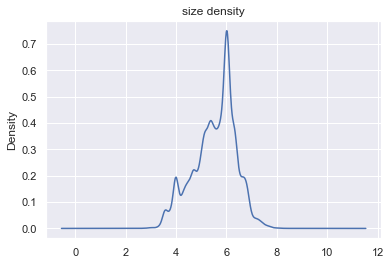

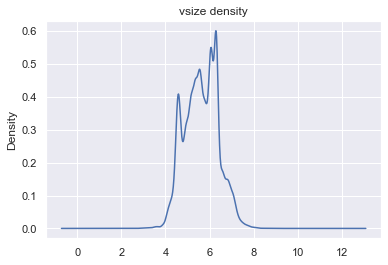

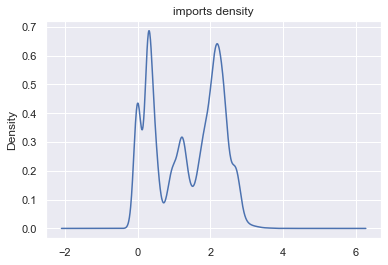

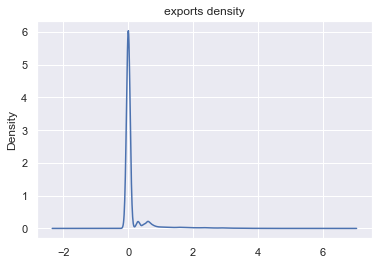

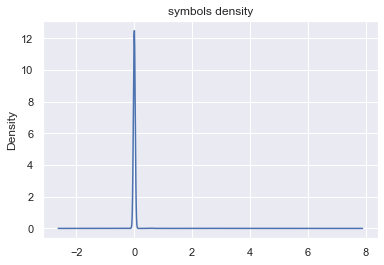

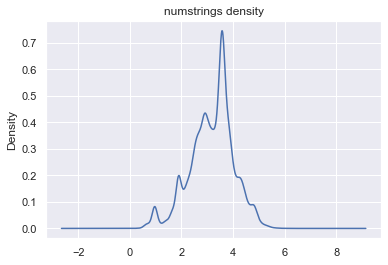

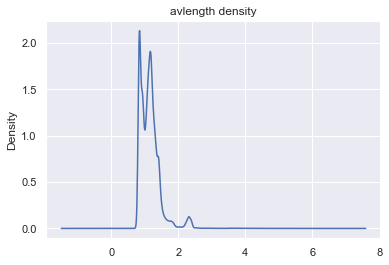

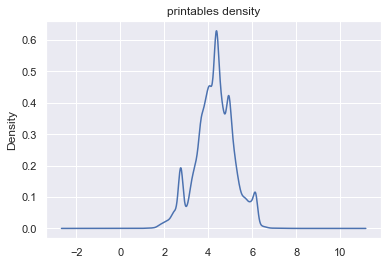

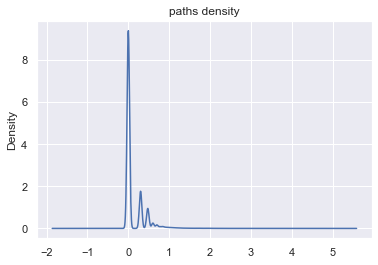

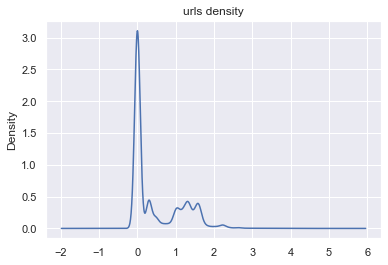

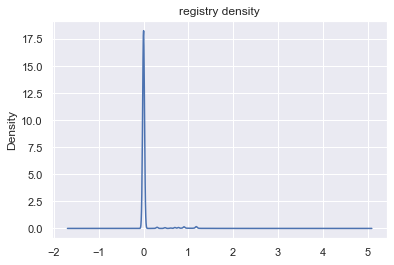

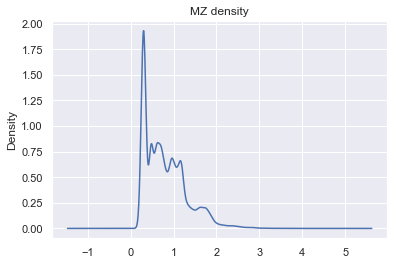

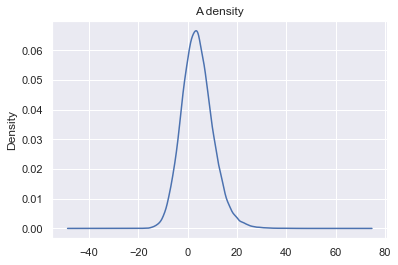

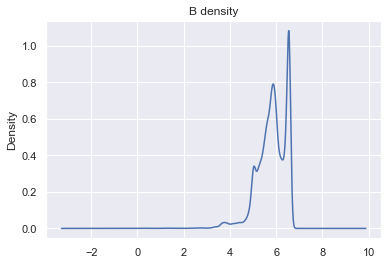

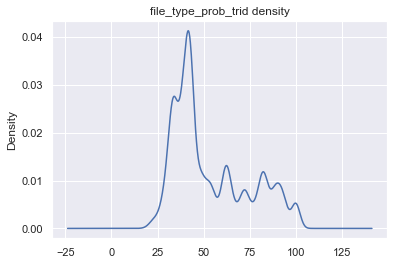

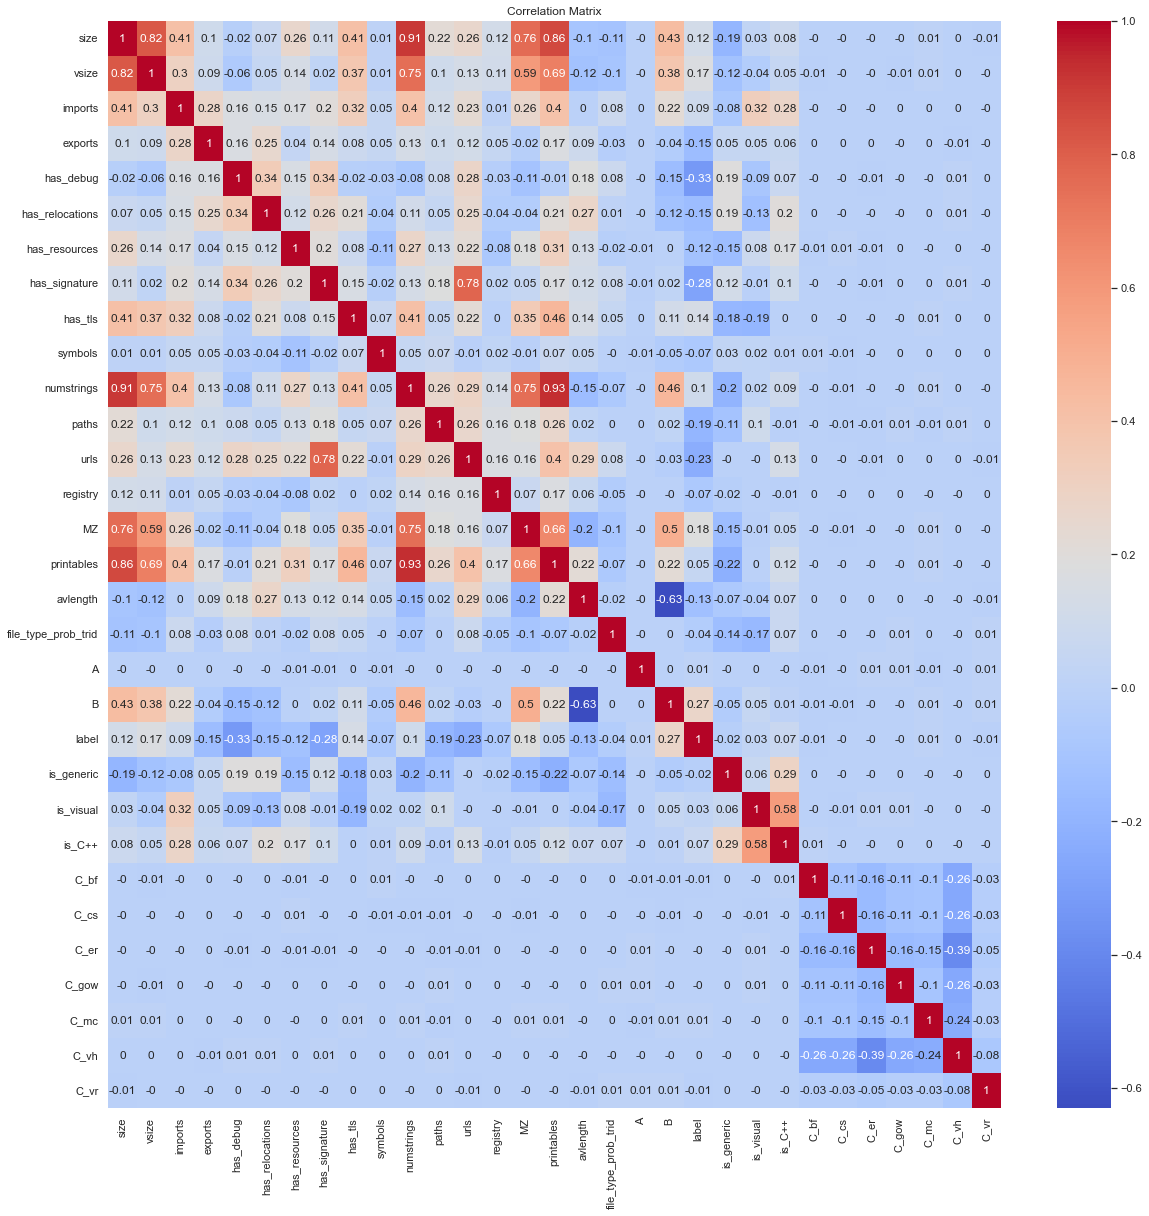

In [99]:
### lets define the log_df

train_df = cat_df.copy()

for feature in to_log:
    train_df[feature] = np.log10(train_df[feature]+1) # so 0 features will be ok
    
train_df.head()

train_df['C'].fillna("unknown", inplace=True)
test_mut = c_test.copy()

# and turn C into a catagorial feature

C_val = cat_df["C"].unique()
print(C_val)
C_val[-1] = 'unknown'


#this will make the same adjustments to the test df, if something is not in the original c values its None
test_mut.loc[~test_mut['C'].isin(C_val), 'C'] = None
test_mut['C'].fillna("unknown", inplace=True)

#
enc = OneHotEncoder()
enc.fit(train_df[['C']])
#

dummy_variables = enc.transform(train_df[['C']]).toarray()
dummy_df = pd.DataFrame(dummy_variables, columns=enc.get_feature_names_out(['C']))
train_df = pd.concat([train_df, dummy_df], axis=1)
train_df.drop(["C", 'C_unknown'],axis=1, inplace=True)

dummy_variables = enc.transform(test_mut[['C']]).toarray()
dummy_df = pd.DataFrame(dummy_variables, columns=enc.get_feature_names_out(['C']))
test_mut = pd.concat([test_mut, dummy_df], axis=1)
test_mut.drop(["C", 'C_unknown'],axis=1, inplace=True)

for col in numerical:
    train_df[col].plot.density()
    plt.title(col+" density")
    plt.show()
corr_matrix = train_df.corr().round(2)
plt.figure(figsize=(20, 20))
sns.heatmap(corr_matrix, cmap='coolwarm', annot=True)
plt.title("Correlation Matrix")
plt.show()

features to remove:

features with low variance:
1. symbols
2. registry
3. exports

features that are corr with others:

1. size
2. vsize
3. numstrings


In [100]:
removed_features = ['symbols', 'registry', 'exports', 'size', 'vsize', 'numstrings']
train_df.drop(removed_features, axis=1, inplace=True)

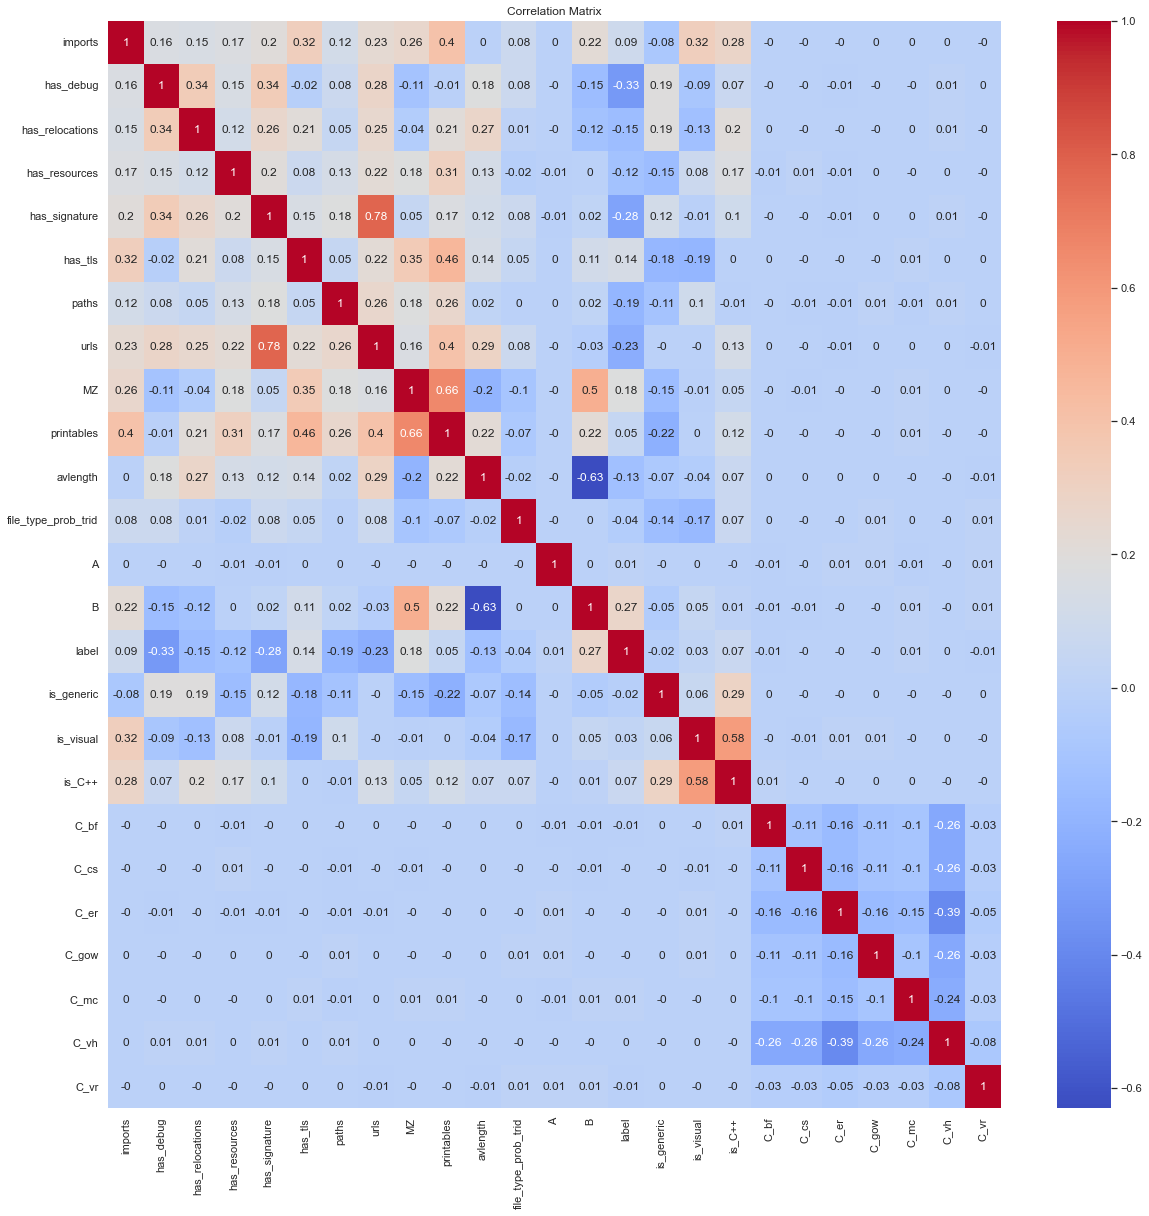

In [101]:

corr_matrix = train_df.corr().round(2)
plt.figure(figsize=(20, 20))
sns.heatmap(corr_matrix, cmap='coolwarm', annot=True)
plt.title("Correlation Matrix")
plt.show()

Step 2: removing outliers

if feature is normally distributed then we will use boxplot

else: we will use isolation forest

In [105]:
# step 1: using boxplot

for norm in normal_log:
    if (norm in removed_features):
        continue
    train_df = train_df[np.abs(stats.zscore(train_df[norm]))<3]
    
    
# step 2: isolation forest
### removing outliers with isolation forest

non_normal_log = ['MZ', 'urls', 'paths', 'avlength']

outlier_clf = IsolationForest(max_samples=100, random_state = 1, contamination= 'auto')

pred = outlier_clf.fit_predict(log_df[non_normal_log])
log_df = log_df[pred==1]
    
log_df.head()
    

In [108]:
### removing outliers with isolation forest

non_normal_log = ['MZ', 'urls', 'paths', 'avlength']

outlier_clf = IsolationForest(max_samples=100, random_state = 1, contamination= 'auto')

pred = outlier_clf.fit_predict(train_df[non_normal_log])
log_df = log_df[pred==1]
    
log_df.head()

ValueError: Input X contains NaN.
IsolationForest does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [52]:
# normalizing the data

st_test = test_mut.copy()
log_test = test_mut.copy()
df_normalized = standard_df.copy()

sc = StandardScaler()
#for numeric in numerical:
   #df_normalized[numeric] = (df_normalized[numeric]-df_normalized[numeric].min())/(df_normalized[numeric].max()-df_normalized[numeric].min())
  #df_normalized.head()

log_normalized = log_df.copy()

#log_normalized.head()
log_test.head()

,sha256,size,vsize,imports,exports,has_debug,has_relocations,has_resources,has_signature,has_tls,symbols,numstrings,paths,urls,registry,MZ,printables,avlength,file_type_trid,file_type_prob_trid,A,B,is_generic,is_visual,is_C++,C_bf,C_cs,C_er,C_gow,C_mc,C_vh,C_vr
0,023928c14abe04196d45bb4578b8fa0eb02189898ce93b...,964814,2072576.0,2.0,30.803271,0.0,0.0,-1.0,0.0,0.0,0.0,4021.0,0.0,0.000000,0.0,14.0,22934.0,5.703556,Win32 Executable (generic),42.7,-1.414118,6.554459,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,6436083d4eed84436768d66829b961927eeb9de2e6657f...,116736,200704.0,136.0,0.000000,1.0,1.0,1.0,0.0,0.0,0.0,365.0,1.0,0.000000,0.0,5.0,7445.0,20.397260,Win32 Executable MS Visual C++ (generic),48.8,4.015404,5.581053,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,038e71f41fdc5edb3a7afc112fb0679a4a5d6d94512055...,3091456,118784.0,124.0,1.000000,0.0,1.0,1.0,0.0,0.0,0.0,13421.0,12.0,0.000000,0.0,9.0,148608.0,11.072796,InstallShield setup,24.1,-1.713507,6.103680,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,be913ef29b4566e7817a5ab2c4a4289a455e9b562e1da0...,1249792,1257472.0,0.0,0.000000,1.0,1.0,1.0,0.0,0.0,0.0,6486.0,0.0,12.501292,0.0,2.0,121156.0,18.679618,Win32 Executable (generic),33.1,9.215390,5.418556,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,e78f83f0af4f1fbcf8fffd562b4734701483818078bf0e...,2117632,2142208.0,165.0,0.000000,0.0,0.0,1.0,0.0,0.0,0.0,2864.0,4.0,0.000000,0.0,2.0,21562.0,7.528631,Win32 Executable Microsoft Visual Basic 6,84.4,2.224768,5.810361,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


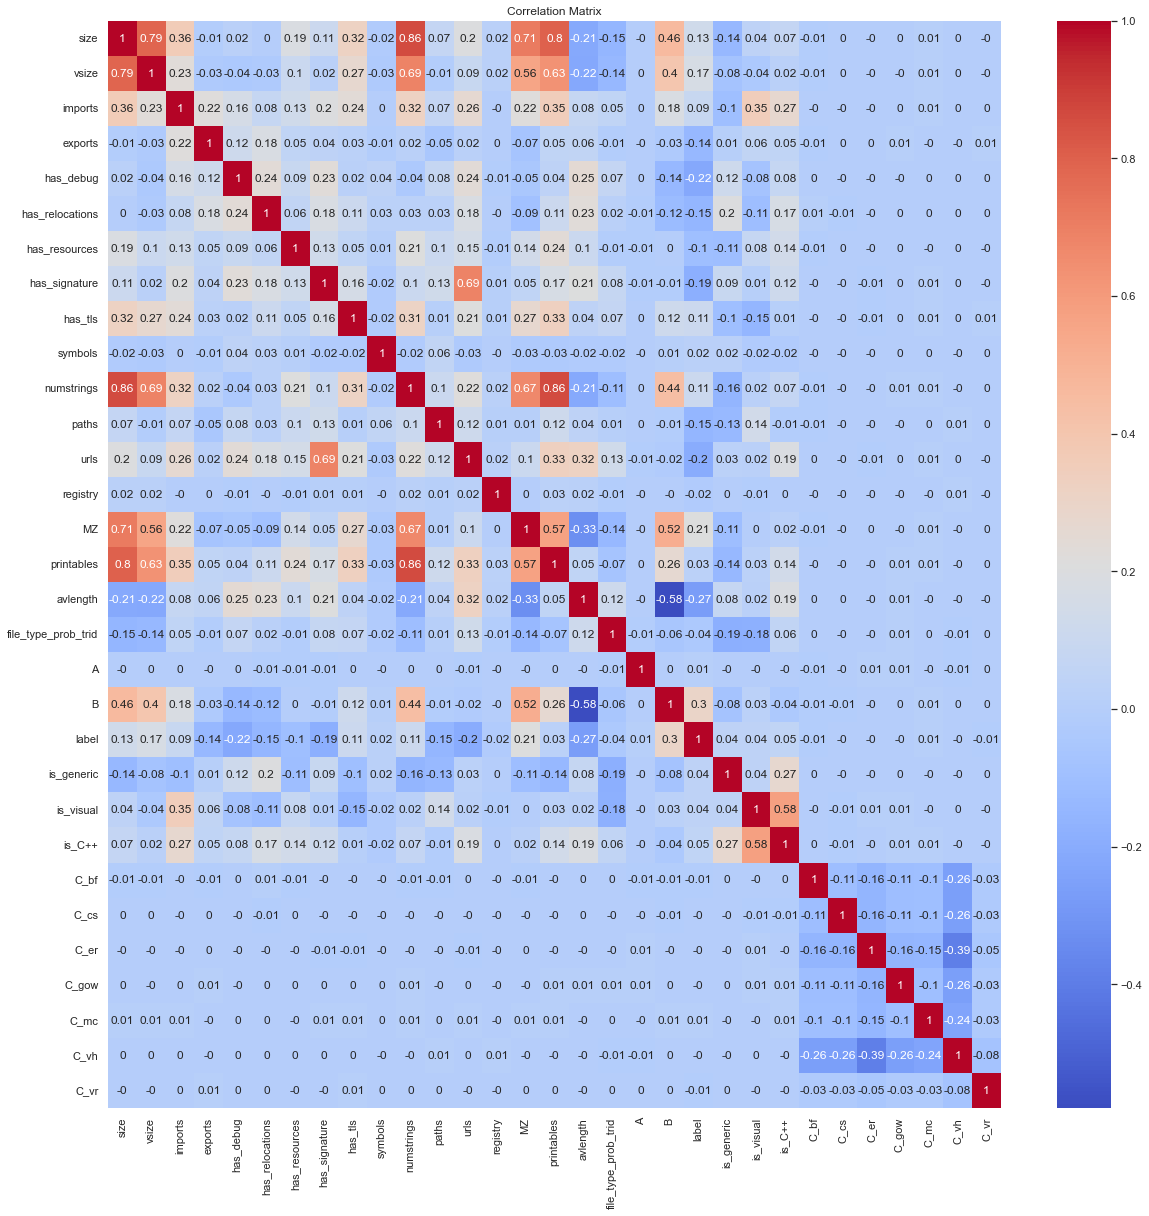

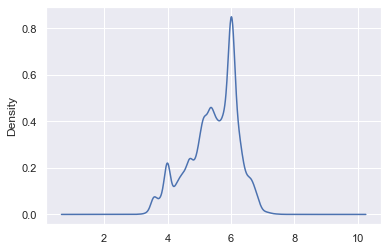

In [53]:
corr_matrix = log_normalized.corr().round(2)
plt.figure(figsize=(20, 20))
sns.heatmap(corr_matrix, cmap='coolwarm', annot=True)
plt.title("Correlation Matrix")
plt.show()

log_normalized['size'].plot.density()
plt.show()

In [54]:
log_removed_features = ['sha256','file_type_trid', 'avlength']
#log_removed_features = ['sha256','size', 'vsize', 'avlength', 'numstrings', 'file_type_prob_trid', 'file_type_trid']
st_removed_featuers  = ['sha256','size', 'vsize', 'numstrings', 'file_type_prob_trid','file_type_trid']


log_test.drop(log_removed_features, axis=1, inplace=True)
log_test.head()


for numeric in log_test.columns:
    log_normalized[numeric] = sc.fit_transform(log_normalized[numeric].values.reshape(-1, 1))
    log_test[numeric] = sc.transform(log_test[numeric].values.reshape(-1, 1))


log_normalized.describe()
#log_test.drop(log_removed_features, axis=1, inplace=True)

,size,vsize,imports,exports,has_debug,has_relocations,has_resources,has_signature,has_tls,symbols,numstrings,paths,urls,registry,MZ,printables,avlength,file_type_prob_trid,A,B,label,is_generic,is_visual,is_C++,C_bf,C_cs,C_er,C_gow,C_mc,C_vh,C_vr
count,4.652100e+04,4.652100e+04,4.652100e+04,4.652100e+04,4.652100e+04,4.652100e+04,4.652100e+04,4.652100e+04,4.652100e+04,4.652100e+04,4.652100e+04,4.652100e+04,4.652100e+04,4.652100e+04,4.652100e+04,4.652100e+04,46521.000000,4.652100e+04,4.652100e+04,4.652100e+04,46521.000000,4.652100e+04,4.652100e+04,4.652100e+04,4.652100e+04,4.652100e+04,4.652100e+04,4.652100e+04,4.652100e+04,4.652100e+04,4.652100e+04
mean,-6.812022e-16,8.803698e-16,1.638093e-17,6.445455e-17,-1.466265e-17,-2.168850e-17,7.484060e-17,-1.221887e-17,-4.826455e-17,6.414908e-18,-1.747299e-16,-7.331324e-18,1.034786e-16,1.832831e-18,-1.234106e-16,-1.771737e-16,1.111712,3.629005e-16,1.557906e-17,8.780788e-16,0.537284,-1.728971e-16,-4.337700e-17,-5.437398e-17,2.107756e-17,-1.557906e-17,-1.072970e-17,-2.550690e-17,-3.314369e-17,-2.749246e-17,-4.398794e-17
std,1.000011e+00,1.000011e+00,1.000011e+00,1.000011e+00,1.000011e+00,1.000011e+00,1.000011e+00,1.000011e+00,1.000011e+00,1.000011e+00,1.000011e+00,1.000011e+00,1.000011e+00,1.000011e+00,1.000011e+00,1.000011e+00,0.225491,1.000011e+00,1.000011e+00,1.000011e+00,0.498613,1.000011e+00,1.000011e+00,1.000011e+00,1.000011e+00,1.000011e+00,1.000011e+00,1.000011e+00,1.000011e+00,1.000011e+00,1.000011e+00
min,-3.118055e+00,-3.746798e+00,-1.518682e+00,-2.995958e-01,-2.357874e+00,-2.399262e+00,-3.712651e+00,-2.548266e+00,-2.448941e+00,-3.702896e-02,-3.104364e+00,-5.572628e-01,-6.886073e-01,-2.774358e-02,-1.135899e+00,-3.907903e+00,0.782593,-1.717344e+00,-3.537910e+00,-9.327850e+00,0.000000,-2.083384e+00,-5.078073e-01,-6.859361e-01,-3.264797e-01,-3.311356e-01,-4.892885e-01,-3.237313e-01,-3.058706e-01,-7.947148e-01,-1.026413e-01
25%,-5.936089e-01,-7.197385e-01,-1.179460e+00,-2.995958e-01,-5.838054e-01,-7.231689e-01,4.393812e-01,-3.980886e-01,-3.101461e-01,-3.702896e-02,-6.116852e-01,-5.572628e-01,-6.886073e-01,-2.774358e-02,-1.135899e+00,-5.980446e-01,0.926264,-7.599770e-01,-6.539595e-01,-4.937717e-01,0.000000,4.799883e-01,-5.078073e-01,-6.859361e-01,-3.264797e-01,-3.311356e-01,-4.892885e-01,-3.237313e-01,-3.058706e-01,-7.947148e-01,-1.026413e-01
50%,1.617362e-01,-1.526337e-03,2.212836e-01,-2.995958e-01,-5.838054e-01,-7.231689e-01,4.393812e-01,-3.980886e-01,-3.101461e-01,-3.702896e-02,1.457170e-01,-5.572628e-01,-6.886073e-01,-2.774358e-02,-1.826908e-01,1.320522e-01,1.102718,-5.147401e-01,-5.406137e-04,1.451724e-03,1.000000,4.799883e-01,-5.078073e-01,-6.859361e-01,-3.264797e-01,-3.311356e-01,-4.892885e-01,-3.237313e-01,-3.058706e-01,-7.947148e-01,-1.026413e-01
75%,7.596344e-01,7.541969e-01,8.926859e-01,-2.995958e-01,1.190263e+00,9.529241e-01,4.393812e-01,-3.980886e-01,-3.101461e-01,-3.702896e-02,6.439373e-01,1.086412e+00,9.673350e-01,-2.774358e-02,8.113188e-01,7.238039e-01,1.245606,8.387788e-01,5.699972e-01,8.491291e-01,1.000000,4.799883e-01,-5.078073e-01,1.457862e+00,-3.264797e-01,-3.311356e-01,-4.892885e-01,-3.237313e-01,-3.058706e-01,1.258313e+00,-1.026413e-01
max,3.113930e+00,4.745187e+00,2.613328e+00,8.187562e+00,1.190263e+00,9.529241e-01,4.393812e-01,1.752089e+00,1.828648e+00,5.688401e+01,3.379927e+00,5.864396e+00,4.400686e+00,2.128471e+02,4.794218e+00,4.679736e+00,2.263318,2.145137e+00,6.476051e+00,1.242575e+00,1.000000,4.799883e-01,1.969251e+00,1.457862e+00,3.062978e+00,3.019911e+00,2.043784e+00,3.088982e+00,3.269357e+00,1.258313e+00,9.742668e+00


In [55]:
X_log = log_normalized.copy()
X_log.drop(log_removed_features, axis=1, inplace=True)
X_log.drop('label', axis=1, inplace=True) # for obvious reasons

#preform the splits

y_log = log_normalized['label']

Xlog_train, Xlog_val, ylog_train, ylog_val = train_test_split(X_log, y_log, test_size=0.2, random_state=42, shuffle=True)

# labels
#lr = LogisticRegression(penalty = 'l2', solver="liblinear")

# we will do PCA in order to further reduce dimensions
for variance in [0.5, 0.6, 0.7, .8, .9, 0.95, 0.99, 0.995, .9999]:
    pca = PCA(variance)
    data = pca.fit_transform(Xlog_train)
    print("For explained variance:", variance, "number of dimensions:", data.shape[1])
#log_train = scaler.fit_transform(X_log)
pca = PCA(0.99)

pca.fit(Xlog_train)
X_train_reduced = pca.transform(Xlog_train)
X_val_reduced = pca.transform(Xlog_val)
#X_log_reduced = pca.fit_transform(X_log)
l_test_reduced = pca.transform(log_test)
#X_log_reduced = X_log

powers = range(-10,1)
Cs = [10**p for p in powers] #This is the inverse value for the lambda parameter.



lr = LogisticRegression(solver = 'liblinear', penalty = 'l2')
params = {'C' : Cs,
         'fit_intercept' : [True, False]}
cv = GridSearchCV(lr, param_grid=params, scoring='roc_auc',verbose=3)
cv.fit(X_train_reduced, ylog_train)

best_lr = cv.best_estimator_
pred = best_lr.predict_proba(X_val_reduced)[:,1]

val_auc = metrics.roc_auc_score(ylog_val, pred)
print("Validation set auc for the log df:",val_auc)

For explained variance: 0.5 number of dimensions: 8
For explained variance: 0.6 number of dimensions: 11
For explained variance: 0.7 number of dimensions: 13
For explained variance: 0.8 number of dimensions: 16
For explained variance: 0.9 number of dimensions: 20
For explained variance: 0.95 number of dimensions: 23
For explained variance: 0.99 number of dimensions: 26
For explained variance: 0.995 number of dimensions: 28
For explained variance: 0.9999 number of dimensions: 29
Fitting 5 folds for each of 22 candidates, totalling 110 fits
[CV 1/5] END .......C=1e-10, fit_intercept=True;, score=0.739 total time=   0.0s
[CV 2/5] END .......C=1e-10, fit_intercept=True;, score=0.732 total time=   0.0s
[CV 3/5] END .......C=1e-10, fit_intercept=True;, score=0.745 total time=   0.0s
[CV 4/5] END .......C=1e-10, fit_intercept=True;, score=0.747 total time=   0.0s
[CV 5/5] END .......C=1e-10, fit_intercept=True;, score=0.740 total time=   0.0s
[CV 1/5] END ......C=1e-10, fit_intercept=False;, 

In [56]:
r_clf = ensemble.RandomForestClassifier()

r_clf.fit(X_train_reduced, ylog_train)
pred = r_clf.predict_proba(X_val_reduced)[:,1]
val_auc = metrics.roc_auc_score(ylog_val, pred)
print(val_auc)

0.9515905575008429


In [57]:
model = KNeighborsClassifier()
kparams = {'n_neighbors': range(1, 100, 10)}
kcv = GridSearchCV(model, param_grid=kparams, scoring = 'roc_auc', verbose=3)
kcv.fit(X_train_reduced, ylog_train)

best_clf = kcv.best_estimator_
pred = best_clf.predict_proba(X_val_reduced)[:,1]

val_auc = metrics.roc_auc_score(ylog_val, pred)
print("Validation set auc for the log df:",val_auc)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END .....................n_neighbors=1;, score=0.828 total time=   0.2s
[CV 2/5] END .....................n_neighbors=1;, score=0.817 total time=   0.2s
[CV 3/5] END .....................n_neighbors=1;, score=0.820 total time=   0.2s
[CV 4/5] END .....................n_neighbors=1;, score=0.823 total time=   0.2s
[CV 5/5] END .....................n_neighbors=1;, score=0.814 total time=   0.2s
[CV 1/5] END ....................n_neighbors=11;, score=0.913 total time=   0.2s
[CV 2/5] END ....................n_neighbors=11;, score=0.910 total time=   0.2s
[CV 3/5] END ....................n_neighbors=11;, score=0.912 total time=   0.2s
[CV 4/5] END ....................n_neighbors=11;, score=0.913 total time=   0.2s
[CV 5/5] END ....................n_neighbors=11;, score=0.915 total time=   0.2s
[CV 1/5] END ....................n_neighbors=21;, score=0.911 total time=   0.2s
[CV 2/5] END ....................n_neighbors=21;